In [1]:
#imports 
import pandas as pd 
from collections import Counter
import re
import seaborn as sns

In [2]:
multimer_one_chain = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/multimer_onechain_clu_cluster.tsv', sep = '\t', header=None)
multimer_one_chain[0] = [re.split('\.', i)[0] for i in multimer_one_chain[0]]
multimer_one_chain[1] = [re.split('\.', i)[0] for i in multimer_one_chain[1]]

monomers = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/monomer_clu_cluster.tsv', sep = '\t', header=None)
multimer = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/multimer_clu_cluster.tsv', sep = '\t', header=None)

In [3]:
# count the number of non-singleton clusters in multimer cluster
multimer_counts = pd.DataFrame.from_dict(Counter(multimer[0]), orient='index')
multimer_counts_nonsingletoncounts = len(multimer_counts[multimer_counts[0] != 1]) 

# count the number of non-singleton clusters in multimer one chain
multimer_one_chain_counts = pd.DataFrame.from_dict(Counter(multimer_one_chain[0]), orient='index')
multimer_one_chain_counts_nonsingletoncounts= len(multimer_one_chain_counts[multimer_one_chain_counts[0] != 1]) 

# count the number of monomer clusters 
monomer_counts = pd.DataFrame.from_dict(Counter(monomers[0]), orient='index')
monomer_counts_nonsingletoncounts= len(monomer_counts[monomer_counts[0] != 1]) 

In [4]:
monomer_clusters = [set(monomers[monomers[0] == f][1]) for f in list(set(monomers[0]))]
multimer_clusters = [set(multimer[multimer[0] == f][1]) for f in list(set(multimer[0]))]
multimer_one_chain_clusters = [set(multimer_one_chain[multimer_one_chain[0] == f][1]) for f in list(set(multimer_one_chain[0]))]

In [5]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import itertools

# First, get all unique protein IDs
all_proteins = sorted(set().union(*monomer_clusters, *multimer_clusters, *multimer_one_chain_clusters))

# Helper to convert cluster sets -> label array
def clusters_to_labels(clusters, proteins):
    protein_to_label = {}
    for label, cluster in enumerate(clusters):
        for protein in cluster:
            protein_to_label[protein] = label
    return [protein_to_label.get(p, -1) for p in proteins]  # -1 if missing

labels_mono = clusters_to_labels(monomer_clusters, all_proteins)
labels_multi = clusters_to_labels(multimer_clusters, all_proteins)
labels_multi1 = clusters_to_labels(multimer_one_chain_clusters, all_proteins)

# Pairwise comparisons
ari_mm = adjusted_rand_score(labels_mono, labels_multi)
ari_mmo = adjusted_rand_score(labels_mono, labels_multi1)
ari_mmo_m = adjusted_rand_score(labels_multi, labels_multi1)

nmi_mm = normalized_mutual_info_score(labels_mono, labels_multi)
nmi_mmo = normalized_mutual_info_score(labels_mono, labels_multi1)
nmi_mmo_m = normalized_mutual_info_score(labels_multi, labels_multi1)

print(f"Monomer vs Multimer: ARI={ari_mm:.3f}, NMI={nmi_mm:.3f}")
print(f"Monomer vs Multimer (one chain): ARI={ari_mmo:.3f}, NMI={nmi_mmo:.3f}")
print(f"Multimer vs Multimer (one chain): ARI={ari_mmo_m:.3f}, NMI={nmi_mmo_m:.3f}")



Monomer vs Multimer: ARI=0.127, NMI=0.972
Monomer vs Multimer (one chain): ARI=0.507, NMI=0.979
Multimer vs Multimer (one chain): ARI=0.123, NMI=0.972


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ------------------------ helpers ------------------------
def method_stats(clusters):
    sizes = [len(c) for c in clusters]
    n_clusters = len(sizes)
    singletons = sum(1 for s in sizes if s == 1)
    non_singletons = n_clusters - singletons

    sizes_non = [s for s in sizes if s >= 2]  # non-singleton cluster sizes

    unique_proteins = len(set().union(*clusters)) if clusters else 0  # assuming a partition
    # coverage = fraction of proteins that are in non-singleton clusters
    proteins_in_non_singletons = sum(s for s in sizes if s >= 2)
    coverage = proteins_in_non_singletons / unique_proteins if unique_proteins else 0.0

    return {
        "clusters": n_clusters,
        "singletons": singletons,
        "non_singleton_clusters": non_singletons,
        "proteins": unique_proteins,

        # overall size stats (all clusters)
        "mean_size": float(np.mean(sizes)) if sizes else 0.0,
        "median_size": float(np.median(sizes)) if sizes else 0.0,
        "std_size": float(np.std(sizes)) if sizes else 0.0,
        "min_size": int(min(sizes)) if sizes else 0,
        "max_size": int(max(sizes)) if sizes else 0,
        "p90_size": float(np.percentile(sizes, 90)) if sizes else 0.0,

        # coverage
        "coverage_non_singleton_proteins": coverage,

        # NEW: non-singleton-only stats
        "mean_size_non_singleton": float(np.mean(sizes_non)) if sizes_non else 0.0,
        "max_size_non_singleton": int(max(sizes_non)) if sizes_non else 0,
    }

def cluster_id_map(clusters):
    """protein -> cluster_label (0..K-1)"""
    m = {}
    for lbl, c in enumerate(clusters):
        for p in c:
            m[p] = lbl
    return m

def labels_for_proteins(clusters, proteins, missing=-1):
    m = cluster_id_map(clusters)
    return [m.get(p, missing) for p in proteins]

def mean_max_jaccard(A, B):
    """For each cluster in A, take max Jaccard to any cluster in B, then average."""
    if not A or not B:
        return 0.0
    scores = []
    for a in A:
        best = 0.0
        for b in B:
            u = len(a | b)
            if u:
                j = len(a & b) / u
                if j > best:
                    best = j
        scores.append(best)
    return float(np.mean(scores)) if scores else 0.0

def identical_cluster_counts(A, B):
    """Counts of exactly identical clusters between methods (all & non-singletons)."""
    A_fs = {frozenset(c) for c in A}
    B_fs = {frozenset(c) for c in B}
    inter_all = A_fs & B_fs
    inter_non = {c for c in inter_all if len(c) >= 2}
    return len(inter_all), len(inter_non)

def singleton_sets(clusters):
    """Set of protein IDs that are singletons in this method."""
    return {next(iter(c)) for c in clusters if len(c) == 1}

def pairwise_stats(nameA, A, nameB, B):
    # protein universes
    proteins_A = set().union(*A) if A else set()
    proteins_B = set().union(*B) if B else set()
    union = sorted(proteins_A | proteins_B)
    inter = sorted(proteins_A & proteins_B)

    # labels (union: missing = -1; intersection: both present)
    yA_u = labels_for_proteins(A, union, missing=-1)
    yB_u = labels_for_proteins(B, union, missing=-1)
    yA_i = labels_for_proteins(A, inter, missing=-1)
    yB_i = labels_for_proteins(B, inter, missing=-1)

    ari_union = adjusted_rand_score(yA_u, yB_u) if union else np.nan
    nmi_union = normalized_mutual_info_score(yA_u, yB_u) if union else np.nan
    ari_inter = adjusted_rand_score(yA_i, yB_i) if inter else np.nan
    nmi_inter = normalized_mutual_info_score(yA_i, yB_i) if inter else np.nan

    # Jaccard (both directions)
    j_a2b = mean_max_jaccard(A, B)
    j_b2a = mean_max_jaccard(B, A)
    j_mean = (j_a2b + j_b2a) / 2.0

    # identical clusters (exact same member sets)
    ident_all, ident_non = identical_cluster_counts(A, B)

    # singleton overlaps
    sA, sB = singleton_sets(A), singleton_sets(B)
    singleton_overlap = len(sA & sB)

    return {
        "A": nameA, "B": nameB,
        "proteins_union": len(union),
        "proteins_intersection": len(inter),
        "ARI_union": ari_union,
        "NMI_union": nmi_union,
        "ARI_intersection": ari_inter,
        "NMI_intersection": nmi_inter,
        "mean_max_jaccard_A→B": j_a2b,
        "mean_max_jaccard_B→A": j_b2a,
        "mean_max_jaccard_bidir": j_mean,
        "identical_clusters_all": ident_all,
        "identical_clusters_non_singleton": ident_non,
        "singleton_overlap_proteins": singleton_overlap,
    }

# ------------------------ build the tables ------------------------
methods = {
    "Monomer": monomer_clusters,
    "Multimer": multimer_clusters,
    "OneChain": multimer_one_chain_clusters,
}

# per-method table
method_rows = []
for name, cl in methods.items():
    row = {"method": name}
    row.update(method_stats(cl))
    method_rows.append(row)
method_summary = pd.DataFrame(method_rows).set_index("method").sort_index()

# pairwise table
pairs = [("Monomer","Multimer"), ("Monomer","OneChain"), ("Multimer","OneChain")]
pair_rows = []
for a,b in pairs:
    pair_rows.append(pairwise_stats(a, methods[a], b, methods[b]))
pair_summary = pd.DataFrame(pair_rows)

# pretty formats
with pd.option_context('display.float_format', lambda v: f"{v:.3f}"):
    display(method_summary)
    display(pair_summary)

# (optional) save to CSV
# method_summary.to_csv("cluster_method_summary.csv")
# pair_summary.to_csv("cluster_pairwise_summary.csv")



,clusters,singletons,non_singleton_clusters,proteins,mean_size,median_size,std_size,min_size,max_size,p90_size,coverage_non_singleton_proteins,mean_size_non_singleton,max_size_non_singleton
method,,,,,,,,,,,,,
Monomer,5227,4504,723,6902,1.320,1.000,1.432,1,44,2.000,0.347,3.317,44
Multimer,6488,6248,240,6902,1.064,1.000,0.455,1,15,1.000,0.095,2.725,15
OneChain,5239,4542,697,6901,1.317,1.000,1.488,1,52,2.000,0.342,3.385,52


,A,B,proteins_union,proteins_intersection,ARI_union,NMI_union,ARI_intersection,NMI_intersection,mean_max_jaccard_A→B,mean_max_jaccard_B→A,mean_max_jaccard_bidir,identical_clusters_all,identical_clusters_non_singleton,singleton_overlap_proteins
0,Monomer,Multimer,6902,6902,0.127,0.972,0.127,0.972,0.907,0.782,0.845,4406,54,4352
1,Monomer,OneChain,6902,6901,0.507,0.979,0.507,0.979,0.920,0.919,0.920,4458,269,4189
2,Multimer,OneChain,6902,6901,0.123,0.972,0.123,0.972,0.786,0.912,0.849,4464,63,4401


Comparing the Monomer and OneChain clusterings, global structure is highly consistent (NMI = 0.979) with moderate exact-membership agreement (ARI = 0.507) and near-symmetric correspondence (mean-max Jaccard ≈ 0.92 in both directions). Much of the headline overlap is driven by proteins that are singletons in both methods (4189/6902, 60.7%), yielding 4458 identical clusters when singletons are included. Restricting to multi-member clusters, 269 clusters are identical across the two methods, indicating that OneChain largely preserves monomer-level granularity and is a suitable substitute when precise boundaries matter.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Map old names to new descriptive ones (with line breaks)
name_map = {
    "Monomer": "Foldseek\n(Monomers)",
    "Multimer": "Foldseek-Multimer\n(Full assemblies)",
    "OneChain": "Foldseek\n(Single-Chain Multimers)"
}

sns.set(style='white')

# Build graph from ARI_intersection in pair_summary
G = nx.Graph()
methods_list = list(name_map.values())
G.add_nodes_from(methods_list)

for _, row in pair_summary.iterrows():
    G.add_edge(
        name_map[row["A"]],
        name_map[row["B"]],
        weight=row["ARI_intersection"]
    )

# Layout
pos = nx.circular_layout(G, scale=1.2)  # scale slightly to spread nodes apart

plt.figure(figsize=(7.45, 7.45))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="#ADD8E6", edgecolors="black")
nx.draw_networkx_edges(G, pos, width=3, edge_color="grey")

# Shifted node labels to appear next to the nodes
label_pos = {'Foldseek\n(Monomers)': (1.2, 0.48000002384185816),
 'Foldseek-Multimer\n(Full assemblies)': (-0.600000089406968,
  1.5192305000546623),
 'Foldseek\n(Single-Chain Multimers)': (-0.5999999105930319,
  -1.55)}
nx.draw_networkx_labels(G, label_pos, font_size=14, font_weight="bold", verticalalignment="center")

# Edge labels
edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, font_size=14, font_weight="bold",
    bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.2")
)

plt.axis("off")
plt.margins(0.55)

# Save with extra padding so nothing is cut off
plt.savefig("ari_network.png", dpi=300, bbox_inches="tight", pad_inches=0.4, transparent=True)
plt.show()


## upset plot showing whether the clusters are unique

In [10]:
import upsetplot
print(upsetplot.__version__)

0.9.0


In [ ]:
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships

# ---------- consistent naming ----------
name_map = {
    "Monomer":  "Foldseek\n(Monomers)",
    "Multimer": "Foldseek-Multimer\n(Full assemblies)",
    "OneChain": "Foldseek\n(Single-Chain Multimers)",
}
LAB_MONO  = name_map["Monomer"]
LAB_MULTI = name_map["Multimer"]
LAB_OC    = name_map["OneChain"]

# ----- inputs: your three lists of cluster sets -----
# monomer_clusters, multimer_clusters, multimer_one_chain_clusters

# ----- keep only non-singleton clusters and canonicalize as frozensets -----
def non_singleton_fsets(cluster_list):
    return {frozenset(c) for c in cluster_list if len(c) >= 2}

mono_ns  = non_singleton_fsets(monomer_clusters)
multi_ns = non_singleton_fsets(multimer_clusters)
oc_ns    = non_singleton_fsets(multimer_one_chain_clusters)

# Universe of cluster-objects
all_clusters = mono_ns | multi_ns | oc_ns

# Memberships per cluster
def membership_methods(cluster):
    labs = []
    if cluster in mono_ns:  labs.append(LAB_MONO)
    if cluster in multi_ns: labs.append(LAB_MULTI)
    if cluster in oc_ns:    labs.append(LAB_OC)
    return labs

memberships = [membership_methods(c) for c in all_clusters]

# Build Series for upsetplot
series = from_memberships(memberships)
series = series.groupby(level=list(range(series.index.nlevels))).size()

# ---- plot ----
plt.figure(figsize=(10, 8))
up = UpSet(
    series,
    sort_by="cardinality",
    show_counts=True,
    sort_categories_by=None,
    element_size=40  # increases bar and label size
)
up.plot()

# Increase label sizes for all text
plt.rcParams.update({'font.size': 14})  # general font size

# Save and show
plt.savefig("upset_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

# ---- numeric summary ----
only_mono   = len(mono_ns  - (multi_ns | oc_ns))
only_multi  = len(multi_ns - (mono_ns  | oc_ns))
only_oc     = len(oc_ns    - (mono_ns  | multi_ns))
mono_multi  = len((mono_ns & multi_ns) - oc_ns)
mono_oc     = len((mono_ns & oc_ns)    - multi_ns)
multi_oc    = len((multi_ns & oc_ns)   - mono_ns)
all_three   = len(mono_ns & multi_ns & oc_ns)

print("\nIdentical non-singleton clusters (counts):")
print(f"{LAB_MONO} only: {only_mono}")
print(f"{LAB_MULTI} only: {only_multi}")
print(f"{LAB_OC} only: {only_oc}")
print(f"{LAB_MONO} ∩ {LAB_MULTI} (only): {mono_multi}")
print(f"{LAB_MONO} ∩ {LAB_OC} (only): {mono_oc}")
print(f"{LAB_MULTI} ∩ {LAB_OC} (only): {multi_oc}")
print(f"All three: {all_three}")


## Upset plot of the singleton

In [ ]:
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships

# ---------- consistent naming ----------
name_map = {
    "Monomer":  "Foldseek\n(Monomers)",
    "Multimer": "Foldseek-Multimer\n(Full assemblies)",
    "OneChain": "Foldseek\n(Single-Chain Multimers)",
}
LAB_MONO  = name_map["Monomer"]
LAB_MULTI = name_map["Multimer"]
LAB_OC    = name_map["OneChain"]

# ----- helper -----
def singleton_ids(cluster_list):
    """Return the set of protein IDs that are in singleton clusters (size == 1)."""
    return {next(iter(c)) for c in cluster_list if len(c) == 1}

# Singleton protein IDs per method
mono_s   = singleton_ids(monomer_clusters)
multi_s  = singleton_ids(multimer_clusters)
onech_s  = singleton_ids(multimer_one_chain_clusters)

# Universe of proteins that are singletons in at least one method
all_singletons = mono_s | multi_s | onech_s

# Memberships per protein: which methods is it a singleton in?
def membership_for(p):
    m = []
    if p in mono_s:   m.append(LAB_MONO)
    if p in multi_s:  m.append(LAB_MULTI)
    if p in onech_s:  m.append(LAB_OC)
    return m

memberships = [membership_for(p) for p in all_singletons]

# Build Series for upsetplot
series = from_memberships(memberships)
series = series.groupby(level=list(range(series.index.nlevels))).size()

# ---- plot ----
plt.figure(figsize=(10, 8))
up = UpSet(
    series,
    sort_by='cardinality',
    show_counts=True,
    sort_categories_by=None,
    element_size=40
)
up.plot()

plt.rcParams.update({'font.size': 14})

# Save to PNG
plt.savefig("upset_singletons.png", dpi=300, bbox_inches="tight")
plt.show()

# ---- numeric summary ----
print("Singleton counts per method:")
print(f"  {LAB_MONO}:  {len(mono_s)}")
print(f"  {LAB_MULTI}: {len(multi_s)}")
print(f"  {LAB_OC}: {len(onech_s)}")


In [ ]:
import numpy as np

def mean_max_jaccard(clusters_a, clusters_b):
    scores = []
    for ca in clusters_a:
        if len(ca) == 0:
            continue
        max_j = max(len(ca & cb) / len(ca | cb) for cb in clusters_b)
        scores.append(max_j)
    return np.mean(scores)

print("Monomer → Multimer mean max Jaccard:", mean_max_jaccard(monomer_clusters, multimer_clusters))
print("Monomer → Multimer (1 chain) mean max Jaccard:", mean_max_jaccard(monomer_clusters, multimer_one_chain_clusters))
print("Multimer → Multimer (1 chain) mean max Jaccard:", mean_max_jaccard(multimer_clusters, multimer_one_chain_clusters))


In [8]:
monomer_cluster_counts = pd.DataFrame.from_dict(Counter(monomers[0]), orient='index')
multimer_cluster_counts = pd.DataFrame.from_dict(Counter(multimer_one_chain[0]), orient='index')

In [9]:
monomer_nonsingleton_ids = monomer_cluster_counts[monomer_cluster_counts[0] != 1].index.to_list()
multimer_nonsingleton_ids = multimer_cluster_counts[multimer_cluster_counts[0] != 1].index.to_list()

In [10]:
multimer_one_chain_nonsingletons = multimer_one_chain[multimer_one_chain[0].isin(multimer_nonsingleton_ids)]
monomer_nonsingletons = monomers[monomers[0].isin(monomer_nonsingleton_ids)]

In [11]:
import pandas as pd

# Assume first col is cluster_id, second col is phrog_id
mono = monomer_nonsingletons.rename(columns={0: "mono_cluster", 1: "phrog"})
multi = multimer_one_chain_nonsingletons.rename(columns={0: "multi_cluster", 1: "phrog"})

# Merge on phrog IDs
merged = pd.merge(mono, multi, on="phrog", how="outer")  # outer in case not identical sets


In [12]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score

# Rename cols
mono = monomer_nonsingletons.rename(columns={0: "mono_cluster", 1: "phrog"})
multi = multimer_one_chain_nonsingletons.rename(columns={0: "multi_cluster", 1: "phrog"})

# Outer-merge to inspect coverage
merged = pd.merge(mono, multi, on="phrog", how="outer")

# Coverage stats
only_mono  = merged["multi_cluster"].isna().sum()
only_multi = merged["mono_cluster"].isna().sum()
both       = merged.dropna(subset=["mono_cluster","multi_cluster"]).shape[0]
print(f"Only in monomer: {only_mono} | Only in multimer: {only_multi} | In both: {both}")

# --- ARI needs aligned labels with no NaNs ---
aligned = merged.dropna(subset=["mono_cluster","multi_cluster"]).copy()

# (Optional) ensure they’re strings, not categories with NaN issues
aligned["mono_cluster"]  = aligned["mono_cluster"].astype(str)
aligned["multi_cluster"] = aligned["multi_cluster"].astype(str)

ari = adjusted_rand_score(aligned["mono_cluster"], aligned["multi_cluster"])
print(f"Adjusted Rand Index (over intersection, n={aligned.shape[0]}): {ari:.3f}")


Only in monomer: 354 | Only in multimer: 315 | In both: 2044
Adjusted Rand Index (over intersection, n=2044): 0.572


In [13]:
# do something here with the jaccard index and sets to measure the overlaps 

In [14]:
# read in the phrogs annotations so that these can be overlayed 
# use this so it can be coloured 
phrogs_df = pd.read_csv('/home/grig0076/scratch/databases/phrogs/phrog_annot_v4.tsv', sep='\t')
phrogs_df['phrog']  = ['phrog_' + str(p) for p in phrogs_df['phrog']] 
phrogs_category = dict(zip(phrogs_df['phrog'], phrogs_df['category']))
phrogs_annot = dict(zip(phrogs_df['phrog'], phrogs_df['annot']))

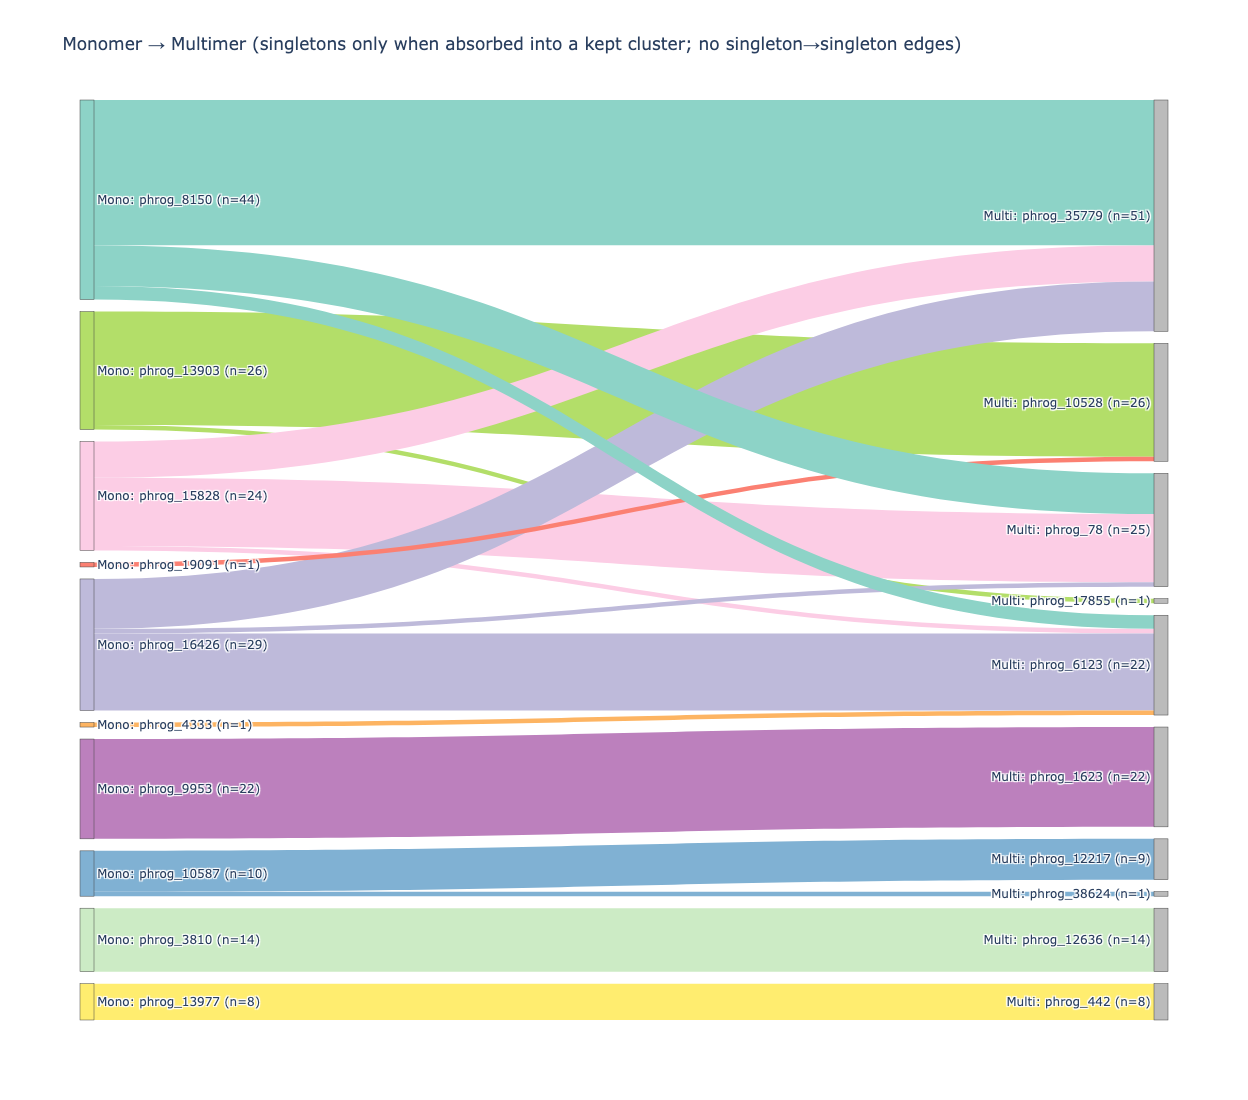

In [42]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# ============== PARAMETERS ==============
TOP_MONO   = 10   # largest NON-singleton monomer clusters (intersection) to show
TOP_MULTI  = 10   # largest NON-singleton multimer clusters (intersection) to show
MIN_LINK   = 1    # drop links with < MIN_LINK items
FIG_H, FIG_W = 1100, 1100

# Palettes (edit if you like)
left_palette = [
        "#fb8072",
     "#fdb462",
    "#8dd3c7",
    "#bebada",
    "#b3de69",
    "#fccde5",
    "#bc80bd",
    "#ccebc5",
            "#80b1d3",
        '#ffed6f',
]

right_palette = ["#BBBBBB"] * 12
# =======================================

def repeat_palette(p, n):
    reps = (n + len(p) - 1) // len(p)
    return (p * reps)[:n]

# ---------- 1) Build intersection table ----------
mono  = monomer_nonsingletons.rename(columns={0: "mono_cluster", 1: "phrog"}).copy()
multi = multimer_one_chain_nonsingletons.rename(columns={0: "multi_cluster", 1: "phrog"}).copy()
merged = pd.merge(mono, multi, on="phrog", how="inner")  # intersection only

merged["mono_cluster"]  = merged["mono_cluster"].astype(str)
merged["multi_cluster"] = merged["multi_cluster"].astype(str)

# ---------- 2) Sizes & top lists (exclude singletons from "top") ----------
mono_sizes  = merged["mono_cluster"].value_counts()
multi_sizes = merged["multi_cluster"].value_counts()

mono_singletons_set  = set(mono_sizes[mono_sizes == 1].index)
multi_singletons_set = set(multi_sizes[multi_sizes == 1].index)

top_mono_non_singleton  = list(mono_sizes[mono_sizes > 1].sort_values(ascending=False).head(TOP_MONO).index)
top_multi_non_singleton = list(multi_sizes[multi_sizes > 1].sort_values(ascending=False).head(TOP_MULTI).index)

# ---------- 3) Keep rules ----------
# Keep a row if:
#  (A) mono in top-mono-non-singleton
#   OR mono is singleton AND multi in top-multi-non-singleton
# AND
#  (B) multi in top-multi-non-singleton
#   OR multi is singleton AND mono in top-mono-non-singleton
# AND
#  (C) NOT (mono is singleton AND multi is singleton)   <-- extra guard to kill singleton→singleton

sub = merged.copy()

keep_left  = sub["mono_cluster"].isin(top_mono_non_singleton) | (
             sub["mono_cluster"].isin(mono_singletons_set) & sub["multi_cluster"].isin(top_multi_non_singleton)
            )
keep_right = sub["multi_cluster"].isin(top_multi_non_singleton) | (
             sub["multi_cluster"].isin(multi_singletons_set) & sub["mono_cluster"].isin(top_mono_non_singleton)
            )
kill_both_singletons = sub["mono_cluster"].isin(mono_singletons_set) & sub["multi_cluster"].isin(multi_singletons_set)

sub = sub[keep_left & keep_right & (~kill_both_singletons)].copy()

# Labels are the actual cluster IDs (no buckets)
sub["mono_labeled"]  = sub["mono_cluster"]
sub["multi_labeled"] = sub["multi_cluster"]

# ---------- 4) Links ----------
links = (sub.groupby(["mono_labeled", "multi_labeled"])
           .size().reset_index(name="count"))
links = links[links["count"] >= MIN_LINK].reset_index(drop=True)
if links.empty:
    raise ValueError("No links after filtering. Increase TOP_* or lower MIN_LINK.")

# ---------- 5) Order nodes: show singletons at the top on each side ----------
mono_label_sizes  = sub.groupby("mono_labeled")["phrog"].count()
multi_label_sizes = sub.groupby("multi_labeled")["phrog"].count()
mono_is_singleton_label  = mono_label_sizes == 1
multi_is_singleton_label = multi_label_sizes == 1

mono_flow  = links.groupby("mono_labeled")["count"].sum().sort_values(ascending=False)
multi_flow = links.groupby("multi_labeled")["count"].sum().sort_values(ascending=False)

def order_nodes_all(nodes, flow, is_singleton_series):
    nodes = [n for n in nodes if n in flow.index]
    singles = [n for n in nodes if bool(is_singleton_series.get(n, False))]
    nons    = [n for n in nodes if not bool(is_singleton_series.get(n, False))]
    singles_sorted = [n for n in flow.index if n in singles]
    nons_sorted    = [n for n in flow.index if n in nons]
    return singles_sorted + nons_sorted

mono_nodes  = order_nodes_all(list(links["mono_labeled"].unique()),  mono_flow,  mono_is_singleton_label)
multi_nodes = order_nodes_all(list(links["multi_labeled"].unique()), multi_flow, multi_is_singleton_label)

# ---------- 6) Map to indices ----------
mono_idx  = {m: i for i, m in enumerate(mono_nodes)}
multi_idx = {m: len(mono_nodes) + j for j, m in enumerate(multi_nodes)}

source = links["mono_labeled"].map(mono_idx).astype(int).tolist()
target = links["multi_labeled"].map(multi_idx).astype(int).tolist()
value  = links["count"].astype(int).tolist()

# ---------- 7) Labels ----------
mono_counts_plot  = links.groupby("mono_labeled")["count"].sum()
multi_counts_plot = links.groupby("multi_labeled")["count"].sum()
label_text = (
    [f"Mono: {m} (n={int(mono_counts_plot[m])})"  for m in mono_nodes] +
    [f"Multi: {m} (n={int(multi_counts_plot[m])})" for m in multi_nodes]
)

# ---------- 8) Colors ----------
node_colors = repeat_palette(left_palette, len(mono_nodes)) + repeat_palette(right_palette, len(multi_nodes))
link_colors = [node_colors[i] for i in source]  # color links by their source

# ---------- 9) Plot ----------
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(label=label_text, pad=12, thickness=14, color=node_colors),
    link=dict(source=source, target=target, value=value, color=link_colors)
))
fig.update_layout(
    title="Monomer → Multimer (singletons only when absorbed into a kept cluster; no singleton→singleton edges)",
    font=dict(size=12), height=FIG_H, width=FIG_W
)
fig.show()


In [8]:
import plotly
print(plotly.__version__)

5.20.0


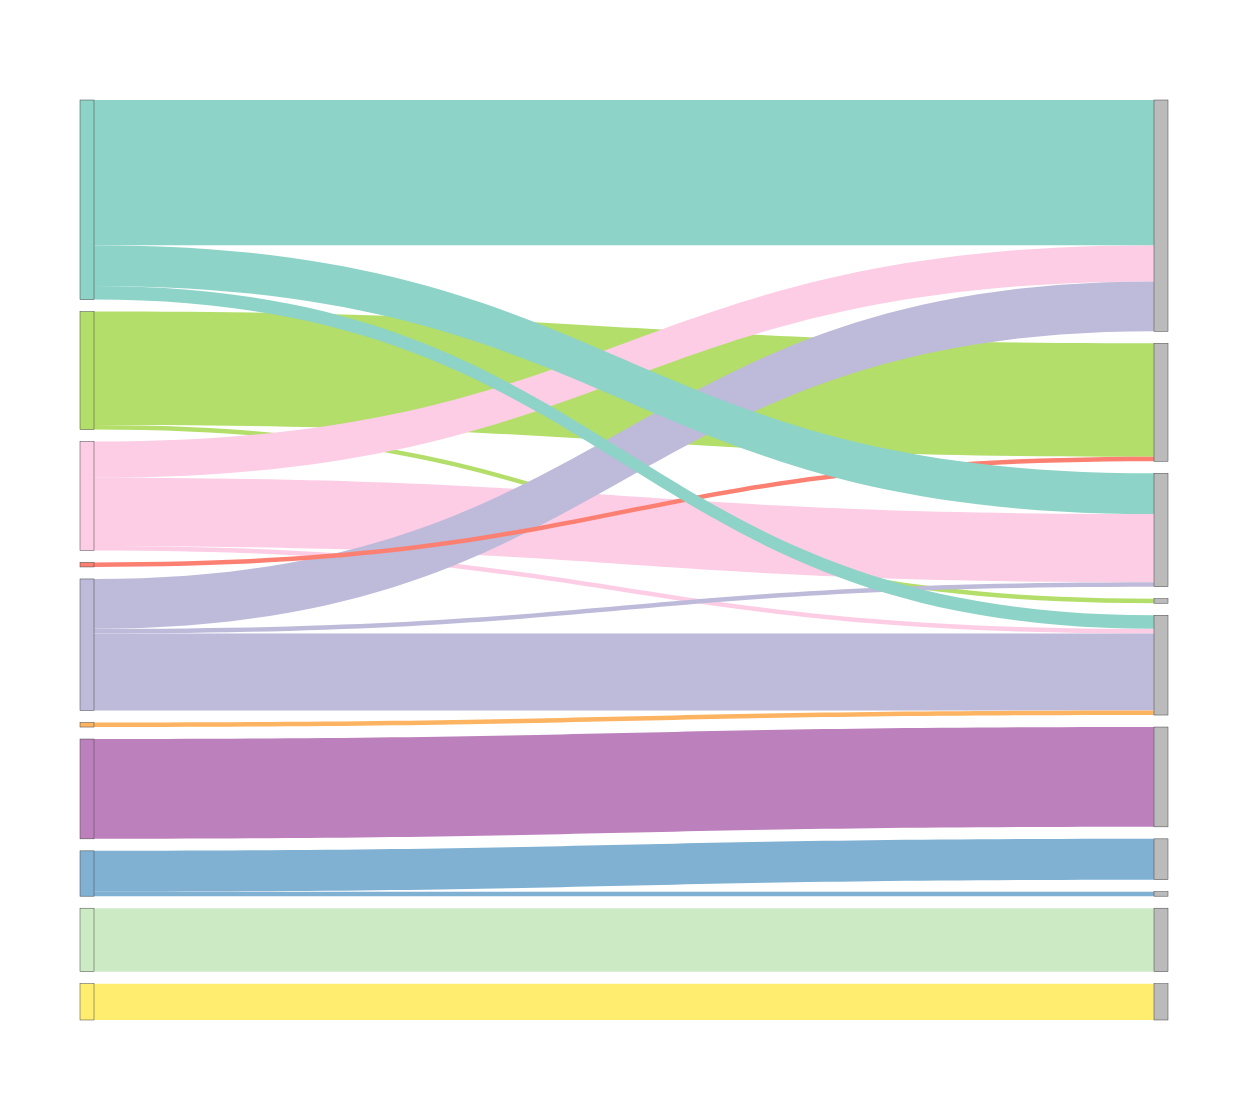

In [43]:
import pandas as pd
import plotly.graph_objects as go

# --- generic labels for nodes (left = monomer, right = multimer) ---
mono_labels_generic  = [f"Monomer cluster {i+1}" for i in range(len(mono_nodes))]
multi_labels_generic = [f"Multimer cluster {j+1}" for j in range(len(multi_nodes))]
label_text = mono_labels_generic + multi_labels_generic
label_text = []
# (optional) mapping from original IDs -> generic labels
mono_name_map  = dict(zip(mono_nodes, mono_labels_generic))
multi_name_map = dict(zip(multi_nodes, multi_labels_generic))

# --- Plot Sankey ---
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        label=label_text,         # generic labels
        pad=12,
        thickness=14,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
))

fig.update_layout(
    title="",
    font=dict(size=20),
    height=FIG_H,
    width=FIG_W
)



fig.show()


igure X. Sankey diagram showing the mapping between monomer clusters (left) and multimer clusters (right) for the 12 largest non-singleton clusters. Singleton clusters are only shown if they connect to a top non-singleton cluster on the opposite side. Node colors distinguish different clusters, while all connecting links are shown in grey to emphasize flow patterns rather than link identity. Link widths are proportional to the number of shared proteins between clusters.

In [18]:
pip show kaleido

Name: kaleido
Version: 1.0.0
Summary: Plotly graph export library
Home-page: 
Author: 
Author-email: Andrew Pikul <ajpikul@gmail.com>, Neyberson Atencio <neyberatencio@gmail.com>
License: The MIT License (MIT)
        
        Copyright (c) Plotly, Inc
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in
        all copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IMPLI